In [1]:
import os


In [2]:
## Kolla bilderna 


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [4]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is 3805-2B52

 Directory of C:\Users\jespe\Pneumonia

01/10/2019  08:01    <DIR>          .
01/10/2019  08:01    <DIR>          ..
01/10/2019  06:41    <DIR>          .ipynb_checkpoints
30/09/2019  17:35    <DIR>          chest_xray
30/09/2019  17:32     2,463,365,435 chest-xray-pneumonia.zip
01/10/2019  08:01         1,027,483 Pneumio_flowy.ipynb
30/09/2019  19:22           332,769 Pneuomonia_kaggle.ipynb
01/10/2019  06:40           332,769 Pneuomonia_kaggle-flowy.ipynb
               4 File(s)  2,465,058,456 bytes
               4 Dir(s)  213,873,745,920 bytes free


In [5]:
training_dir = 'C:\\Users\\jespe\\Pneumonia\\chest_xray\\chest_xray\\train\\'
val_dir = 'C:\\Users\\jespe\\Pneumonia\\chest_xray\\chest_xray\\test\\'
test_dir = 'C:\\Users\\jespe\\Pneumonia\\chest_xray\\chest_xray\\val\\'




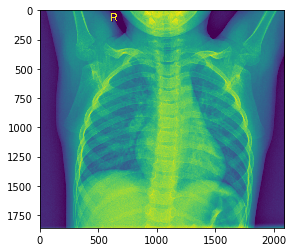

In [6]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [7]:
def plot_images(path, labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(12,6))
    
    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if amount == max_images:
                break
            
            img = mpimg.imread(os.path.join(path,file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img)
            
            amount += 1

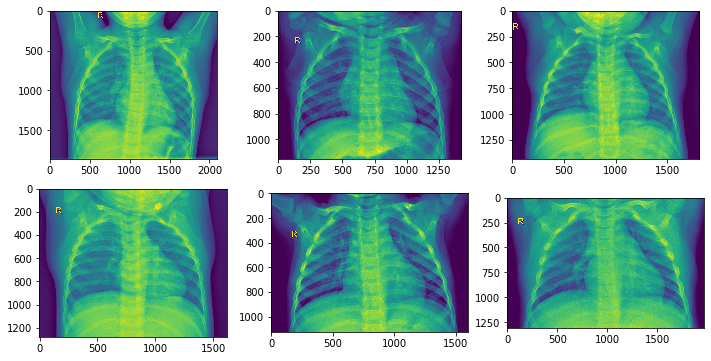

In [8]:
plot_images(training_dir + '/NORMAL')

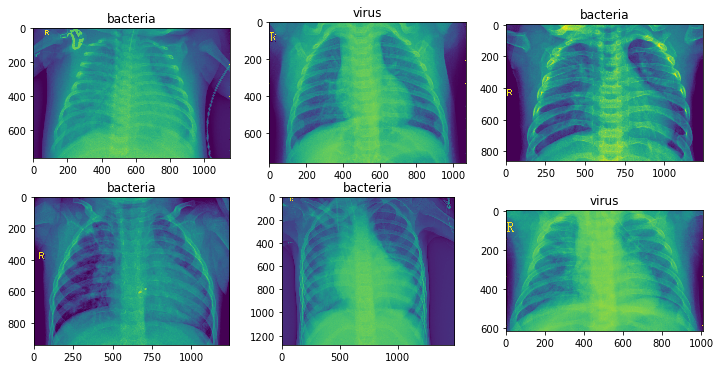

In [9]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)


In [10]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [11]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    predictions = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model.summary()
    return model

In [13]:
model = get_model()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

In [14]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
163/163 [==============================] - 150s 918ms/step - loss: 0.3763 - accuracy: 0.8553 - val_loss: 0.8420 - val_accuracy: 0.7292
Epoch 2/5
163/163 [==============================] - 125s 767ms/step - loss: 0.2610 - accuracy: 0.8965 - val_loss: 1.0622 - val_accuracy: 0.7340
Epoch 3/5
163/163 [==============================] - 139s 852ms/step - loss: 0.2752 - accuracy: 0.8900 - val_loss: 0.8951 - val_accuracy: 0.7324
Epoch 4/5
163/163 [==============================] - 127s 782ms/step - loss: 0.2770 - accuracy: 0.8861 - val_loss: 2.0366 - val_accuracy: 0.6010
Epoch 5/5
163/163 [==============================] - 126s 774ms/step - loss: 0.2426 - accuracy: 0.9026 - val_loss: 1.1917 - val_accuracy: 0.5881


In [15]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 34ms/step
Loss: 0.016421405598521233
Accuracy: 0.625


In [17]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
    y_img_batch, y_true_batch = test_generator[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)
    
    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)
    
y_pred_batches

[array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64),
 array([1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([1], dtype=int64)]

In [22]:
def predict_images(images_path, label):
    amount = 0
    fig = plt.figure(figsize=(18,8))
    
    for file in os.listdir(images_path):
        if file.endswith('.jpeg'):
            if amount == 8:
                break
            
            img = mpimg.imread(os.path.join(images_path, file))
            plt.subplot(241+amount)
            plt.title('{} ----- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
            
            imgplot = plt.imshow(img)
            
            amount += 1

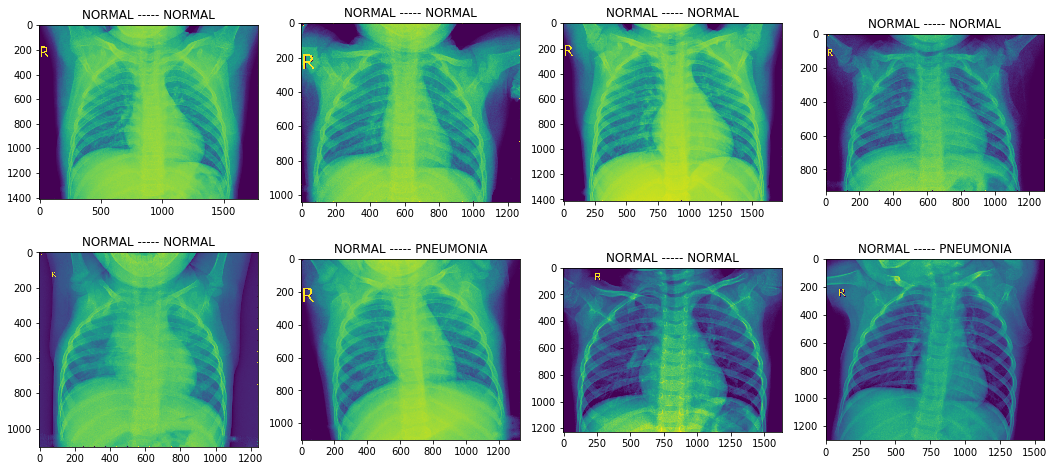

In [23]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

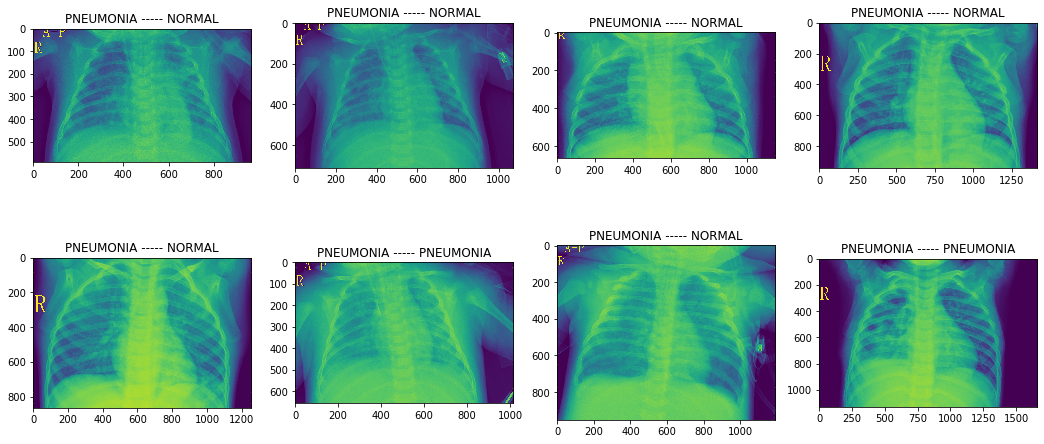

In [24]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [26]:
model.save('awesome_model.h5')

In [27]:
new_model = keras.models.load_model('awesome_model.h5')